In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv("/content/realtor-data-ny.csv")

/tmp/ipython-input-2578130045.py:1: DtypeWarning: Columns (0,4,5,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/realtor-data-ny.csv")


In [ ]:
df.shape

(388925, 11)

In [ ]:
df = df.drop_duplicates()
df = df.dropna(subset=['price','house_size','bed','bath'])
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')

/tmp/ipython-input-655470307.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')


In [ ]:
df.shape

(9161, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9161 entries, 0 to 84039
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status          9161 non-null   object        
 1   bed             9161 non-null   float64       
 2   bath            9161 non-null   float64       
 3   acre_lot        9161 non-null   float64       
 4   city            9159 non-null   object        
 5   state           9161 non-null   object        
 6   zip_code        9159 non-null   float64       
 7   house_size      9161 non-null   float64       
 8   prev_sold_date  6142 non-null   datetime64[ns]
 9   price           9161 non-null   float64       
 10  nyc             9161 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 858.8+ KB


In [ ]:
df.describe()

,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price
count,9161.000000,9161.000000,9161.000000,9159.000000,9161.000000,6142,9.161000e+03
mean,3.888331,2.951970,15.216553,11173.838956,2444.098679,2007-11-02 17:41:35.734288640,1.299758e+06
min,1.000000,1.000000,0.000000,6390.000000,122.000000,1971-03-24 00:00:00,2.000000e+04
25%,3.000000,2.000000,0.060000,10469.000000,1364.000000,2000-08-25 18:00:00,4.800000e+05
50%,4.000000,3.000000,0.140000,10990.000000,1978.000000,2008-07-07 12:00:00,7.399990e+05
75%,5.000000,4.000000,0.660000,11580.000000,2824.000000,2017-02-15 00:00:00,1.249000e+06
max,42.000000,43.000000,100000.000000,14534.000000,112714.000000,2022-10-31 00:00:00,1.690000e+08
std,2.059348,1.798801,1048.639066,858.075659,2415.340981,NaN,3.090303e+06


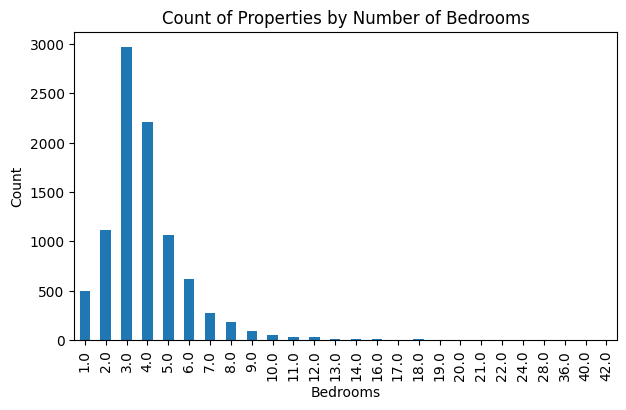

In [ ]:
df['bed'].value_counts().sort_index().plot(kind='bar', figsize=(7,4))
plt.xlabel("Bedrooms")
plt.ylabel("Count")
plt.title("Count of Properties by Number of Bedrooms")
plt.show()

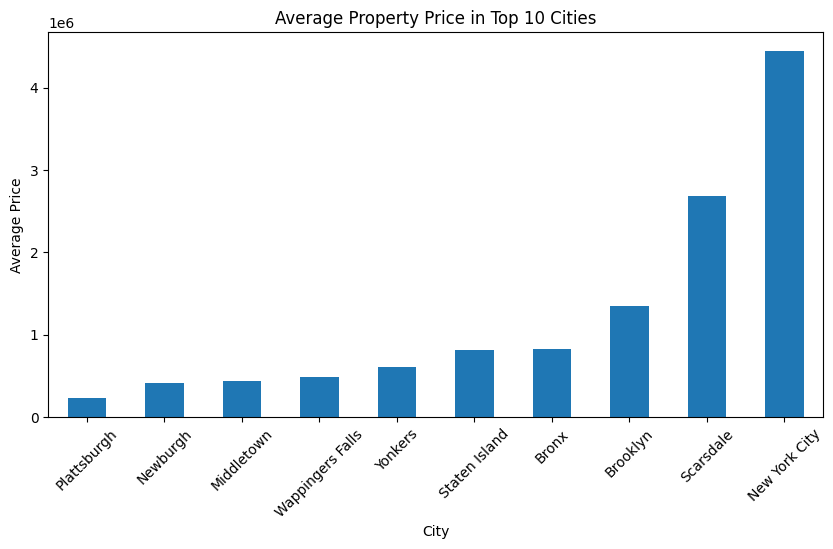

In [ ]:
top_cities = df['city'].value_counts().head(10).index
subset = df[df['city'].isin(top_cities)]

avg_city_price = subset.groupby('city')['price'].mean().sort_values()

plt.figure(figsize=(10,5))
avg_city_price.plot(kind='bar')
plt.title("Average Property Price in Top 10 Cities")
plt.xlabel("City")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

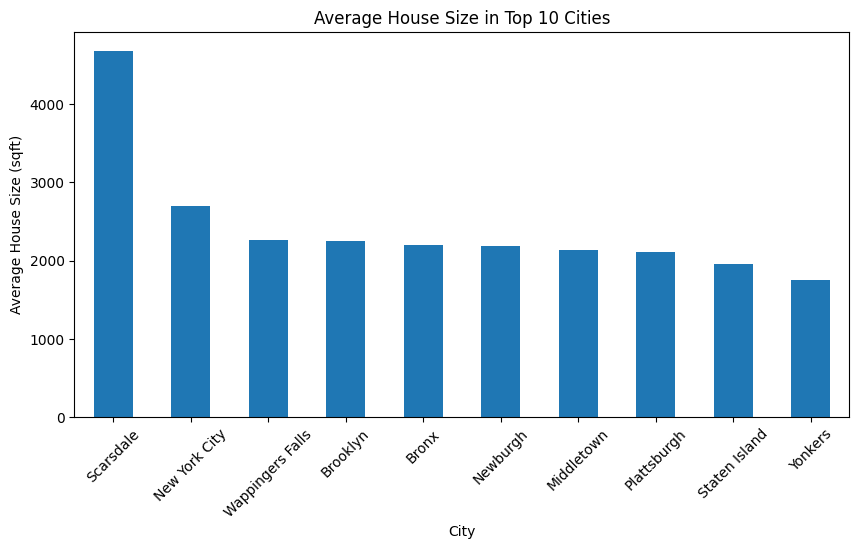

In [ ]:
top_cities = df['city'].value_counts().head(10).index
subset = df[df['city'].isin(top_cities)]

avg_city_size = subset.groupby('city')['house_size'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
avg_city_size.plot(kind='bar')
plt.title("Average House Size in Top 10 Cities")
plt.xlabel("City")
plt.ylabel("Average House Size (sqft)")
plt.xticks(rotation=45)
plt.show()

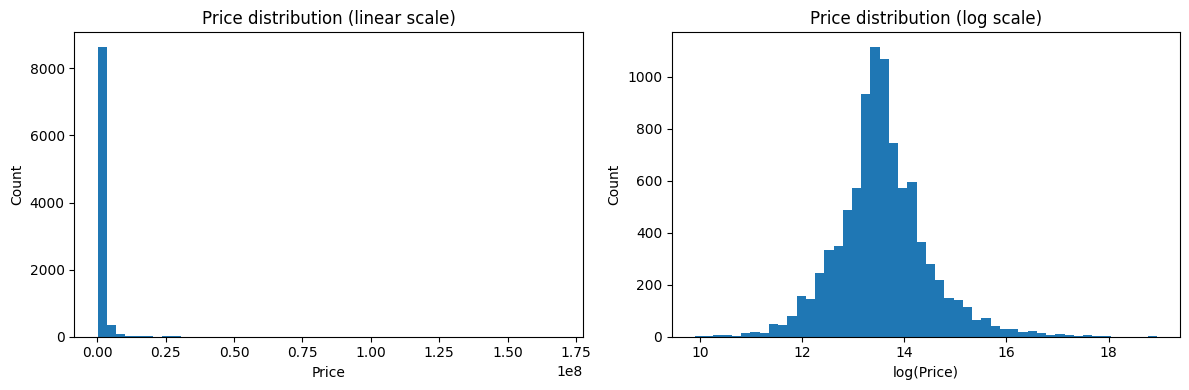

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].hist(df['price'], bins=50)
axes[0].set_title("Price distribution (linear scale)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Count")

axes[1].hist(np.log(df['price']), bins=50)
axes[1].set_title("Price distribution (log scale)")
axes[1].set_xlabel("log(Price)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


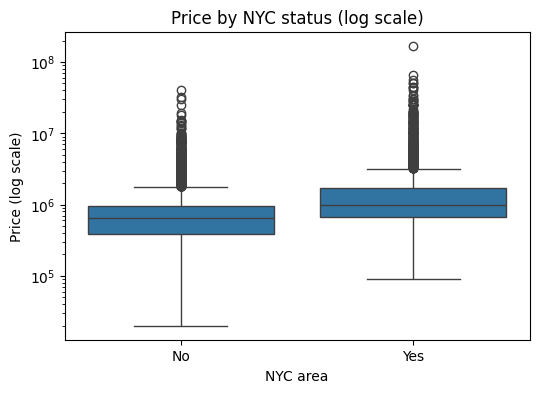

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='nyc', y='price', data=df)
plt.yscale('log')  # helps with skew
plt.title('Price by NYC status (log scale)')
plt.xlabel('NYC area')
plt.ylabel('Price (log scale)')
plt.show()

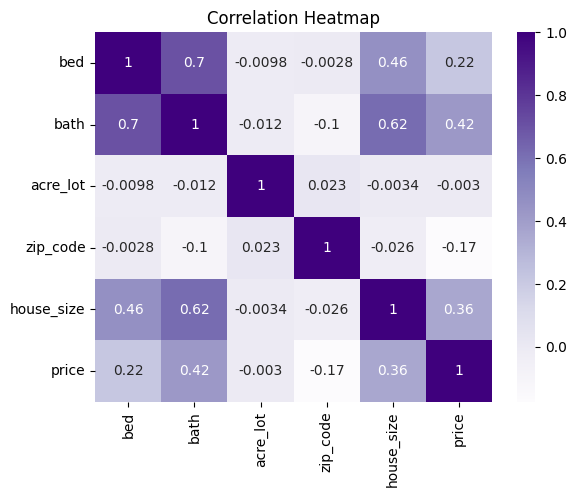

In [ ]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="Purples")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Regression Model
df_reg = df.copy()

df_reg['log_price'] = np.log(df_reg['price'])
df_reg['log_house_size'] = np.log(df_reg['house_size'])
df_reg['log_acre_lot'] = np.log(df_reg['acre_lot'] + 1e-3)
df_reg['nyc_ind'] = (df_reg['nyc'] == 'Yes').astype(int)

df_reg['prev_sold_date_parsed'] = pd.to_datetime(df_reg['prev_sold_date'],
                                                 format='%d/%m/%Y', errors='coerce')
df_reg['prev_year'] = df_reg['prev_sold_date_parsed'].dt.year
df_reg['has_prev'] = df_reg['prev_year'].notna().astype(int)
df_reg['prev_year_filled'] = df_reg['prev_year'].fillna(df_reg['prev_year'].mean())

reg_cols = ['log_price','log_house_size','bed','bath',
            'log_acre_lot','nyc_ind','prev_year_filled','has_prev']
df_reg = df_reg.dropna(subset=reg_cols)

X = df_reg[['log_house_size','bed','bath',
            'log_acre_lot','nyc_ind','prev_year_filled','has_prev']]
y = df_reg['log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Test R^2:", r2)
print("Test RMSE (in log-price):", rmse)
print("Coefficients:", list(zip(X.columns, lin_reg.coef_)))

Test R^2: 0.5560607204655932
Test RMSE (in log-price): 0.5914616708133228
Coefficients: [('log_house_size', np.float64(0.6876736825024611)), ('bed', np.float64(-0.060232148223255504)), ('bath', np.float64(0.1788494590306939)), ('log_acre_lot', np.float64(-0.01776026537969203)), ('nyc_ind', np.float64(0.6604898920379262)), ('prev_year_filled', np.float64(0.0008806341678160085)), ('has_prev', np.float64(-0.026159123223611185))]


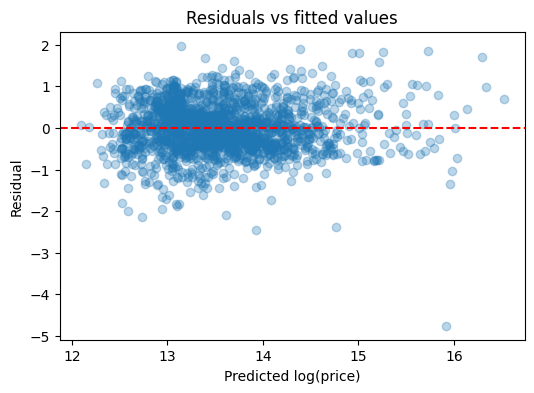

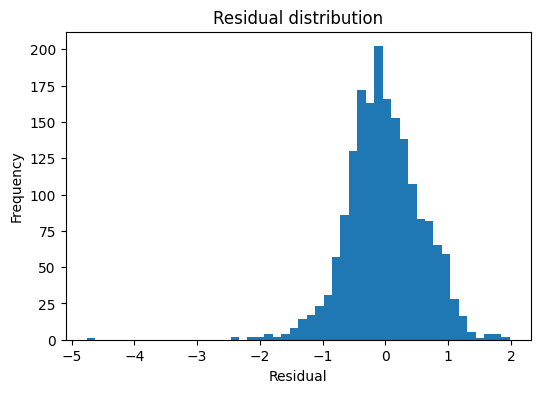

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log(price)')
plt.ylabel('Residual')
plt.title('Residuals vs fitted values')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title('Residual distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1204
           1       0.73      0.70      0.71       629

    accuracy                           0.81      1833
   macro avg       0.79      0.78      0.78      1833
weighted avg       0.81      0.81      0.81      1833

[[1040  164]
 [ 189  440]]


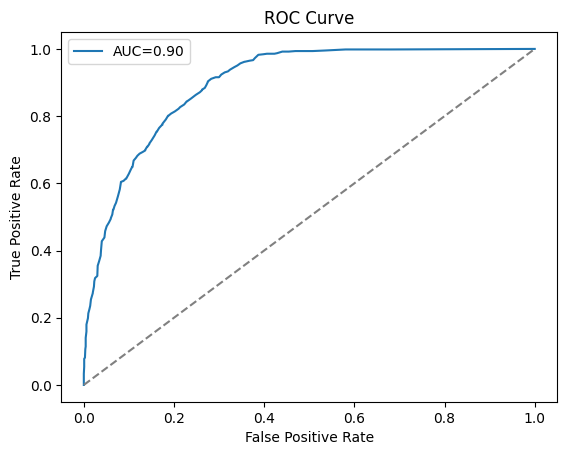

In [ ]:
X = df[["bed","bath","house_size","acre_lot","price"]]
y = df["nyc"].map({"Yes":1,"No":0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
